Importing necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
import plotly.express as px



**Reading and Preprocess the Data**

In [2]:
temp_by_city = pd.read_csv("CLIMATE_GLOBAL/GlobalLandTemperaturesByCity.csv")

temp_by_city_turkey = temp_by_city[temp_by_city['Country'] == 'Turkey']

temp_by_city_turkey

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
3239,1743-11-01,10.013,2.291,Çorlu,Turkey,40.99N,27.69E
3240,1743-12-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
3241,1744-01-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
3242,1744-02-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
3243,1744-03-01,NaN,NaN,Çorlu,Turkey,40.99N,27.69E
...,...,...,...,...,...,...,...
8585430,2013-05-01,17.662,0.196,Zonguldak,Turkey,40.99N,31.95E
8585431,2013-06-01,19.818,0.344,Zonguldak,Turkey,40.99N,31.95E
8585432,2013-07-01,21.343,0.288,Zonguldak,Turkey,40.99N,31.95E
8585433,2013-08-01,22.225,0.454,Zonguldak,Turkey,40.99N,31.95E


In [3]:
fires_00_21 = pd.read_csv("2000_2021_TURKEY/2000-2021 SINGLE TURKEY FIRE_M-C61_214067.csv")

fires_00_21

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
0,36.85270,35.35940,306.00,2.10,1.40,2000-11-01,815,Terra,MODIS,60,6.03,294.40,13.20,D,0.0
1,40.54410,35.17860,307.80,1.10,1.00,2000-11-02,857,Terra,MODIS,66,6.03,296.00,5.80,D,0.0
2,40.14730,35.04440,305.30,1.10,1.00,2000-11-02,857,Terra,MODIS,46,6.03,293.50,4.30,D,0.0
3,40.54210,35.19090,310.00,1.10,1.00,2000-11-02,857,Terra,MODIS,69,6.03,296.10,7.30,D,0.0
4,41.25690,31.41720,307.90,1.10,1.00,2000-11-02,857,Terra,MODIS,0,6.03,290.40,8.00,D,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211304,37.30414,43.69511,330.30,1.02,1.01,2021-08-10,1011,Aqua,MODIS,38,6.1NRT,317.58,10.66,D,NaN
211305,37.05791,27.28960,327.24,1.96,1.37,2021-08-10,1149,Aqua,MODIS,74,6.1NRT,310.40,28.20,D,NaN
211306,38.64441,27.08695,341.95,2.00,1.38,2021-08-10,1149,Aqua,MODIS,88,6.1NRT,310.96,86.83,D,NaN
211307,37.05018,28.84606,342.40,2.48,1.52,2021-08-10,1149,Aqua,MODIS,90,6.1NRT,306.95,142.05,D,NaN


In [4]:
def convert_coordinates(coord_str):
    if coord_str[-1] in ["N","S","W","E"]:
        val = float(coord_str[:-1])
    return val

if temp_by_city_turkey.isnull().values.any(): temp_by_city_turkey = temp_by_city_turkey.dropna()

temp_by_city_turkey["dt"] = temp_by_city_turkey.apply(lambda row: row["dt"].split("-")[0] + "-" +  row["dt"].split("-")[1], axis=1)

temp_by_city_turkey["Latitude"] = temp_by_city_turkey["Latitude"].apply(convert_coordinates)
temp_by_city_turkey["Longitude"] = temp_by_city_turkey["Longitude"].apply(convert_coordinates)

temp_by_city_turkey = temp_by_city_turkey.drop(columns=['Country'])

temp_by_city_turkey

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Latitude,Longitude
3239,1743-11,10.013,2.291,Çorlu,40.99,27.69
3244,1744-04,13.685,2.162,Çorlu,40.99,27.69
3245,1744-05,15.021,1.824,Çorlu,40.99,27.69
3246,1744-06,19.663,1.701,Çorlu,40.99,27.69
3247,1744-07,22.314,1.648,Çorlu,40.99,27.69
...,...,...,...,...,...,...
8585429,2013-04,11.876,0.293,Zonguldak,40.99,31.95
8585430,2013-05,17.662,0.196,Zonguldak,40.99,31.95
8585431,2013-06,19.818,0.344,Zonguldak,40.99,31.95
8585432,2013-07,21.343,0.288,Zonguldak,40.99,31.95


In [5]:
temp_by_city_turkey["Year"] = temp_by_city_turkey.apply(lambda row: int(row["dt"].split("-")[0]), axis=1)
temp_by_city_turkey["Month"] = temp_by_city_turkey.apply(lambda row: int(row["dt"].split("-")[1]), axis=1)

temp_by_city_turkey

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Latitude,Longitude,Year,Month
3239,1743-11,10.013,2.291,Çorlu,40.99,27.69,1743,11
3244,1744-04,13.685,2.162,Çorlu,40.99,27.69,1744,4
3245,1744-05,15.021,1.824,Çorlu,40.99,27.69,1744,5
3246,1744-06,19.663,1.701,Çorlu,40.99,27.69,1744,6
3247,1744-07,22.314,1.648,Çorlu,40.99,27.69,1744,7
...,...,...,...,...,...,...,...,...
8585429,2013-04,11.876,0.293,Zonguldak,40.99,31.95,2013,4
8585430,2013-05,17.662,0.196,Zonguldak,40.99,31.95,2013,5
8585431,2013-06,19.818,0.344,Zonguldak,40.99,31.95,2013,6
8585432,2013-07,21.343,0.288,Zonguldak,40.99,31.95,2013,7


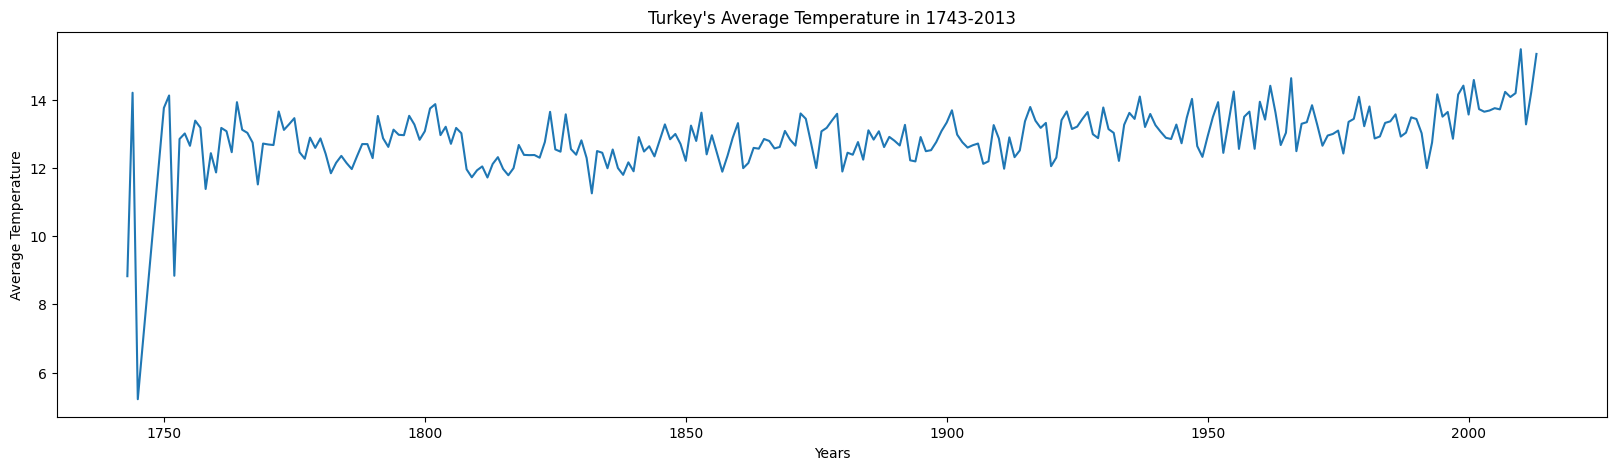

In [6]:
yearly_mean_turkey = temp_by_city_turkey.copy()
yearly_mean_turkey['Date'] = pd.to_datetime(yearly_mean_turkey[['Year', 'Month']].assign(DAY=1))
yearly_mean_turkey = yearly_mean_turkey.groupby(yearly_mean_turkey['Date'].dt.year)['AverageTemperature'].mean().reset_index()
yearly_mean_turkey.columns = ['Year', 'YearlyMeanTemperature']


fig = plt.figure(figsize=(20,5))
plt.plot(np.array(yearly_mean_turkey['Year']), np.array(yearly_mean_turkey['YearlyMeanTemperature']))
plt.xlabel("Years")
plt.ylabel("Average Temperature")
plt.title("Turkey's Average Temperature in 1743-2013")
plt.show()

In [7]:
if fires_00_21.isnull().values.any(): fires_00_21 = fires_00_21.dropna()

fires_00_21["day"] = fires_00_21["daynight"].replace(to_replace=["D","N"], value=[1, 0])


fires_00_21["acq_date"] = fires_00_21.apply(lambda row: row["acq_date"].split("-")[0] + "-" +  row["acq_date"].split("-")[1], axis=1)

fires_00_21["Year"] = fires_00_21.apply(lambda row: int(row["acq_date"].split("-")[0]), axis=1)
fires_00_21["Month"] = fires_00_21.apply(lambda row: int(row["acq_date"].split("-")[1]), axis=1)



fires_00_21 = fires_00_21.drop(columns=['satellite', 'instrument', 'version', 'daynight'])
fires_00_21

,latitude,longitude,brightness,scan,track,acq_date,acq_time,confidence,bright_t31,frp,type,day,Year,Month
0,36.8527,35.3594,306.0,2.1,1.4,2000-11,815,60,294.4,13.2,0.0,1,2000,11
1,40.5441,35.1786,307.8,1.1,1.0,2000-11,857,66,296.0,5.8,0.0,1,2000,11
2,40.1473,35.0444,305.3,1.1,1.0,2000-11,857,46,293.5,4.3,0.0,1,2000,11
3,40.5421,35.1909,310.0,1.1,1.0,2000-11,857,69,296.1,7.3,0.0,1,2000,11
4,41.2569,31.4172,307.9,1.1,1.0,2000-11,857,0,290.4,8.0,2.0,1,2000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205913,39.7165,43.0248,303.6,1.1,1.0,2021-03,812,20,288.6,5.3,2.0,1,2021,3
205914,38.0736,28.1876,302.9,4.0,1.9,2021-03,813,54,287.7,41.8,0.0,1,2021,3
205915,37.5072,28.7670,318.3,1.3,1.1,2021-03,1131,78,291.5,21.8,0.0,1,2021,3
205916,40.1511,28.3499,302.6,1.1,1.0,2021-03,855,53,285.2,6.0,0.0,1,2021,3


In [8]:
unique_cities = temp_by_city_turkey['City'].unique()

city_dfs = {}

for city in unique_cities:
    city_df = temp_by_city_turkey[temp_by_city_turkey['City'] == city]
    city_df = city_df.drop('City',axis = 1)
    city_dfs[city] = city_df

city_dfs["Çorlu"]

,dt,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Year,Month
3239,1743-11,10.013,2.291,40.99,27.69,1743,11
3244,1744-04,13.685,2.162,40.99,27.69,1744,4
3245,1744-05,15.021,1.824,40.99,27.69,1744,5
3246,1744-06,19.663,1.701,40.99,27.69,1744,6
3247,1744-07,22.314,1.648,40.99,27.69,1744,7
...,...,...,...,...,...,...,...
6472,2013-04,13.163,0.591,40.99,27.69,2013,4
6473,2013-05,19.443,0.408,40.99,27.69,2013,5
6474,2013-06,21.758,0.424,40.99,27.69,2013,6
6475,2013-07,23.920,0.433,40.99,27.69,2013,7


Creating a polynomial regression model for predicting the average temperature values in the future.

In [9]:
def create_model(df):
    df_use = df.dropna()

    X = df_use[['Year', 'Month']]
    y = df_use['AverageTemperature']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    degree = 3
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    polyreg.fit(X_train, y_train)

    y_pred = polyreg.predict(X_test)

    return polyreg

In [10]:
model = create_model(city_dfs['Çorlu'])

Temperature predictions for Çorlu in 2017:

In [11]:
predicts = []
for i2 in range(1, 13):
    predicts.append(model.predict([[2017,i2]]))

for i in list(predicts):
    print(*i)

3.6654165786241117
6.546845090460433
9.938755585376143
13.487229861404801
16.83834971657993
19.63819694893491
21.53285335650349
22.16840073731899
21.190920889415143
18.246495610825367
12.981206699583165
5.041135953722115


Calculating yearly mean temperature for doing the polynomial regression model yearly

In [12]:
cities_yearly_dfs = {}

for i in unique_cities:
    city_df = city_dfs['Çorlu']

    yearly_mean = city_df.copy()

    yearly_mean['Date'] = pd.to_datetime(yearly_mean[['Year', 'Month']].assign(DAY=1))

    yearly_mean = yearly_mean.groupby(yearly_mean['Date'].dt.year)['AverageTemperature'].mean().reset_index()

    yearly_mean.columns = ['Year', 'YearlyMeanTemperature']

    cities_yearly_dfs[i] = yearly_mean

cities_yearly_dfs['Çorlu']

,Year,YearlyMeanTemperature
0,1743,10.013000
1,1744,14.934750
2,1745,5.792000
3,1750,13.676636
4,1751,13.999875
...,...,...
262,2009,14.668500
263,2010,15.234917
264,2011,13.577500
265,2012,14.853667


In [13]:
def create_yearly_model(df):
    year = np.array(df['Year'])
    temperature = np.array(df['YearlyMeanTemperature'])

    degree = 3
    coefficients = np.polyfit(year, temperature, degree)

    poly_function = np.poly1d(coefficients)

    fitted_values = np.array(poly_function(year))

    plt.scatter(year, temperature, label='Actual Data')
    plt.plot(year, fitted_values, label=f'Polynomial Regression (Degree {degree})', color='red')
    plt.xlabel('Year')
    plt.ylabel('Yearly Mean Temperature')
    plt.title('Polynomial Regression')
    plt.legend()
    plt.show()

    return poly_function

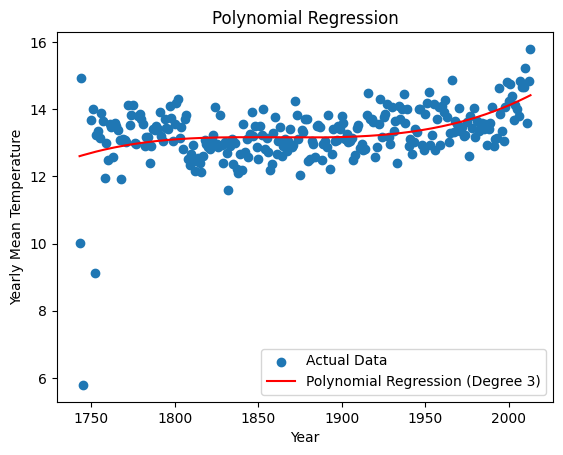

In [14]:
poly = create_yearly_model(cities_yearly_dfs['Çorlu'])

In [15]:
print(poly)
print(poly.coefficients)

           3            2
3.695e-07 x - 0.002063 x + 3.838 x - 2367
[ 3.69533962e-07 -2.06269716e-03  3.83756740e+00 -2.36650171e+03]


In [16]:
poly_deriv = poly.deriv()

print(poly_deriv.coefficients)
print(poly_deriv(2023))

[ 1.10860189e-06 -4.12539432e-03  3.83756740e+00]
0.028880063306382375


Extracting the coordinates of each city for finding cities in wildfires data.

In [17]:
city_coordinates = temp_by_city_turkey[["City", "Latitude", "Longitude"]]
city_coordinates = city_coordinates.drop_duplicates()
city_coordinates = city_coordinates.set_index("City")
city_coordinates

,Latitude,Longitude
City,,
Çorlu,40.99,27.69
Çorum,40.99,34.08
Adana,36.17,35.80
Afyonkarahisar,39.38,31.21
Aksaray,37.78,34.58
Alanya,36.17,31.82
Ankara,39.38,33.29
Antakya,36.17,35.80
Antalya,37.78,30.51


Finding the nearest city for each fire points.

In [18]:
climate_gdf = gpd.GeoDataFrame(city_coordinates, geometry=gpd.points_from_xy(city_coordinates['Longitude'], city_coordinates['Latitude']))
forest_gdf = gpd.GeoDataFrame(fires_00_21, geometry=gpd.points_from_xy(fires_00_21['longitude'], fires_00_21['latitude']))

tree = cKDTree(climate_gdf.geometry.apply(lambda geom: (geom.x, geom.y)).tolist())

def find_nearest_city(point):
    _, idx = tree.query((point.x, point.y))
    nearest_city = climate_gdf.index[idx]
    return nearest_city

forest_gdf['NearestCity'] = forest_gdf.geometry.apply(find_nearest_city)

forest_gdf

,latitude,longitude,brightness,scan,track,acq_date,acq_time,confidence,bright_t31,frp,type,day,Year,Month,geometry,NearestCity
0,36.8527,35.3594,306.0,2.1,1.4,2000-11,815,60,294.4,13.2,0.0,1,2000,11,POINT (35.35940 36.85270),Adana
1,40.5441,35.1786,307.8,1.1,1.0,2000-11,857,66,296.0,5.8,0.0,1,2000,11,POINT (35.17860 40.54410),Samsun
2,40.1473,35.0444,305.3,1.1,1.0,2000-11,857,46,293.5,4.3,0.0,1,2000,11,POINT (35.04440 40.14730),Kayseri
3,40.5421,35.1909,310.0,1.1,1.0,2000-11,857,69,296.1,7.3,0.0,1,2000,11,POINT (35.19090 40.54210),Samsun
4,41.2569,31.4172,307.9,1.1,1.0,2000-11,857,0,290.4,8.0,2.0,1,2000,11,POINT (31.41720 41.25690),Zonguldak
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205913,39.7165,43.0248,303.6,1.1,1.0,2021-03,812,20,288.6,5.3,2.0,1,2021,3,POINT (43.02480 39.71650),Erzurum
205914,38.0736,28.1876,302.9,4.0,1.9,2021-03,813,54,287.7,41.8,0.0,1,2021,3,POINT (28.18760 38.07360),Turgutlu
205915,37.5072,28.7670,318.3,1.3,1.1,2021-03,1131,78,291.5,21.8,0.0,1,2021,3,POINT (28.76700 37.50720),Turgutlu
205916,40.1511,28.3499,302.6,1.1,1.0,2021-03,855,53,285.2,6.0,0.0,1,2021,3,POINT (28.34990 40.15110),Tekirdag


In [19]:
city_grouped = forest_gdf.groupby(["NearestCity","acq_date"]).size().reset_index(name="count")
city_grouped

,NearestCity,acq_date,count
0,Adana,2000-11,104
1,Adana,2000-12,7
2,Adana,2001-01,2
3,Adana,2001-02,1
4,Adana,2001-04,4
...,...,...,...
5347,Çorum,2020-10,12
5348,Çorum,2020-11,7
5349,Çorum,2021-01,1
5350,Çorum,2021-02,10


In [20]:
city_dfs["Çorlu"]

,dt,AverageTemperature,AverageTemperatureUncertainty,Latitude,Longitude,Year,Month
3239,1743-11,10.013,2.291,40.99,27.69,1743,11
3244,1744-04,13.685,2.162,40.99,27.69,1744,4
3245,1744-05,15.021,1.824,40.99,27.69,1744,5
3246,1744-06,19.663,1.701,40.99,27.69,1744,6
3247,1744-07,22.314,1.648,40.99,27.69,1744,7
...,...,...,...,...,...,...,...
6472,2013-04,13.163,0.591,40.99,27.69,2013,4
6473,2013-05,19.443,0.408,40.99,27.69,2013,5
6474,2013-06,21.758,0.424,40.99,27.69,2013,6
6475,2013-07,23.920,0.433,40.99,27.69,2013,7


Merging the temperature value with number of fires values.

In [21]:
mapping = dict(zip(city_dfs["Çorlu"]['dt'], city_dfs["Çorlu"]['AverageTemperature']))

city_grouped1 = city_grouped[city_grouped["acq_date"] <= "2013-08"]
city_grouped2 = city_grouped[city_grouped["acq_date"] > "2013-08"]

city_grouped1['AverageTemperature'] = city_grouped1['acq_date'].map(mapping)
city_grouped1

,NearestCity,acq_date,count,AverageTemperature
0,Adana,2000-11,104,12.714
1,Adana,2000-12,7,8.201
2,Adana,2001-01,2,7.201
3,Adana,2001-02,1,7.011
4,Adana,2001-04,4,12.502
...,...,...,...,...
5268,Çorum,2013-04,8,13.163
5269,Çorum,2013-05,4,19.443
5270,Çorum,2013-06,13,21.758
5271,Çorum,2013-07,8,23.920


Filling the temperature data between 2013-2020 with predictions from polynomial regression model. 

In [22]:
model = create_model(city_dfs['Çorlu'])
data = {"acq_date": [],"AverageTemperature": []}
for year in range(2013,2021):
    
    for month in range(1,13):
       prediction = model.predict([[year,month]])[0]
       str_month = ""
       if month < 10: 
          str_month = "0" + str(int(month))
       else:
          str_month = str(int(month)) 
       data["acq_date"].append(str(int(year)) + "-" + str_month)
       data["AverageTemperature"].append(prediction)

time_temp = pd.DataFrame(data)
time_temp

,acq_date,AverageTemperature
0,2013-01,3.579148
1,2013-02,6.467152
2,2013-03,9.864900
3,2013-04,13.418474
4,2013-05,16.773955
...,...,...
91,2020-08,22.211298
92,2020-09,21.232697
93,2020-10,18.287704
94,2020-11,13.022401


In [23]:
city_grouped2 = city_grouped2[city_grouped2["acq_date"] < "2021-01"]
city_grouped2 = city_grouped2[city_grouped2["acq_date"] > "2013-08"]

mapping = dict(zip(time_temp["acq_date"], time_temp['AverageTemperature']))

city_grouped2['AverageTemperature'] = city_grouped2['acq_date'].map(mapping)
city_grouped2

,NearestCity,acq_date,count,AverageTemperature
146,Adana,2013-09,374,21.136591
147,Adana,2013-10,74,18.192836
148,Adana,2013-11,18,12.927480
149,Adana,2013-12,9,4.986604
150,Adana,2014-01,8,3.600495
...,...,...,...,...
5344,Çorum,2020-07,10,21.577425
5345,Çorum,2020-08,4,22.211298
5346,Çorum,2020-09,41,21.232697
5347,Çorum,2020-10,12,18.287704


In [24]:
city_grouped = pd.concat([city_grouped1, city_grouped2])


city_grouped["Year"] = city_grouped.apply(lambda row: int(row["acq_date"].split("-")[0]), axis=1)
city_grouped["Month"] = city_grouped.apply(lambda row: int(row["acq_date"].split("-")[1]), axis=1)

city_grouped

,NearestCity,acq_date,count,AverageTemperature,Year,Month
0,Adana,2000-11,104,12.714000,2000,11
1,Adana,2000-12,7,8.201000,2000,12
2,Adana,2001-01,2,7.201000,2001,1
3,Adana,2001-02,1,7.011000,2001,2
4,Adana,2001-04,4,12.502000,2001,4
...,...,...,...,...,...,...
5344,Çorum,2020-07,10,21.577425,2020,7
5345,Çorum,2020-08,4,22.211298,2020,8
5346,Çorum,2020-09,41,21.232697,2020,9
5347,Çorum,2020-10,12,18.287704,2020,10


**Evaluating Some Models**


*Linear Regression*

In [25]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor


features = ["NearestCity", "AverageTemperature", 'Year', "Month"]
X = city_grouped[features]
y = city_grouped["count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(), ['NearestCity'])],
    remainder='passthrough'
)


linear_regression_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

linear_regression_model.fit(X_train, y_train)
y_pred_lr = linear_regression_model.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("\nLinear Regression Model")
print(f"Mean Squared Error: {mse_lr}")
print(f"R-squared: {r2_lr}")



Linear Regression Model
Mean Squared Error: 7421.036811656472
R-squared: 0.29172355638785596


*k-Nearest Neighbor Regression*

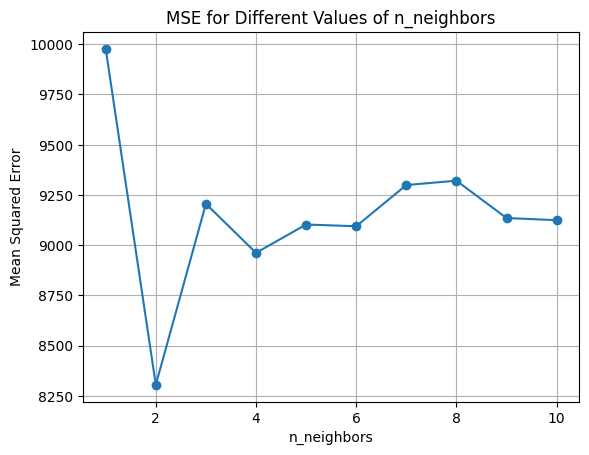

Best n_neighbors based on MSE: 2


In [26]:
kNN_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor(n_neighbors=5)) 
])

k_values = np.arange(1, 11)
mse_values = []

for k in k_values:
    kNN_model.set_params(regressor__n_neighbors=k)
    
    kNN_model.fit(X_train, y_train)
    y_pred_knn = kNN_model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred_knn)
    mse_values.append(mse)

plt.plot(k_values, mse_values, marker='o')
plt.title('MSE for Different Values of n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel('Mean Squared Error')
plt.grid(True)
plt.show()

# Find the value of k that gives the lowest MSE
best_k = k_values[np.argmin(mse_values)]
print(f"Best n_neighbors based on MSE: {best_k}")

In [27]:
best_n_neighbors = best_k

kNN_model.set_params(regressor__n_neighbors=best_n_neighbors)

kNN_model.fit(X_train, y_train)

y_pred_best_knn = kNN_model.predict(X_test)

mse_best_knn = mean_squared_error(y_test, y_pred_best_knn)
r2_best_knn = r2_score(y_test, y_pred_best_knn)

print("\nkNN Regression Model")
print(f"Mean Squared Error: {mse_best_knn}")
print(f"R-squared: {r2_best_knn}")


kNN Regression Model
Mean Squared Error: 8305.100189035917
R-squared: 0.20734703586251368


**Analyzing The Data**

In [28]:
forest_fires_count_cities = pd.read_csv("forest_fires_count_cities.csv")
turkey_climate = pd.read_csv("turkey_climate.csv")
turkey_fires = pd.read_csv("turkey-fires-with-cities.csv")


In [29]:
turkey_climate = turkey_climate.drop('Latitude', axis = 1)
turkey_climate = turkey_climate.drop('Longitude', axis = 1)
turkey_climate = turkey_climate.dropna()
turkey_climate['Year'] = turkey_climate.apply(lambda row: int(row['dt'].split('-')[0]), axis=1)
turkey_climate['Month'] = turkey_climate.apply(lambda row: int(row['dt'].split('-')[1]), axis=1)
turkey_climate = turkey_climate.drop('AverageTemperatureUncertainty', axis = 1)
turkey_climate = turkey_climate.reset_index(drop = True)
turkey_climate.head()

,dt,AverageTemperature,City,Year,Month
0,1743-11-01,10.013,Çorlu,1743,11
1,1744-04-01,13.685,Çorlu,1744,4
2,1744-05-01,15.021,Çorlu,1744,5
3,1744-06-01,19.663,Çorlu,1744,6
4,1744-07-01,22.314,Çorlu,1744,7


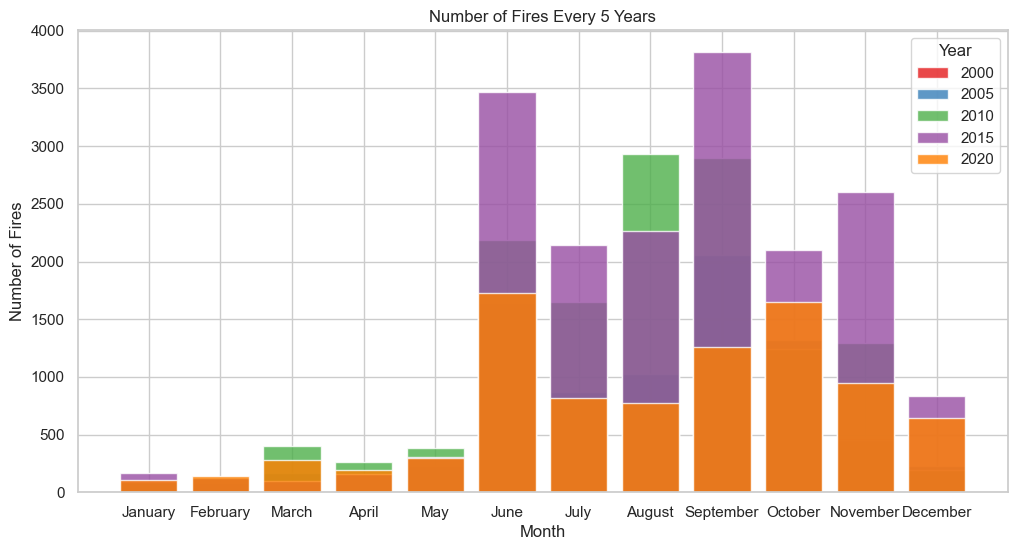

In [30]:
plt.figure(figsize=(12, 6))


sns.set_theme(style="whitegrid")

firesby5years = forest_fires_count_cities.groupby(['Year', 'Month'])['count'].sum().reset_index()


years = sorted(firesby5years['Year'].unique())[::5]


sns.set_palette("Set1", n_colors=len(years))


for year in years:
    data = firesby5years[firesby5years['Year'] == year]
    plt.bar(data['Month'], data['count'], label=year, alpha=0.8)


plt.xlabel('Month')
plt.ylabel('Number of Fires')
plt.title('Number of Fires Every 5 Years')


month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
plt.xticks(ticks=[i for i in range(1,13)], labels=month_names)


plt.legend(title='Year', bbox_to_anchor=(1, 1), labels=years)

plt.show()

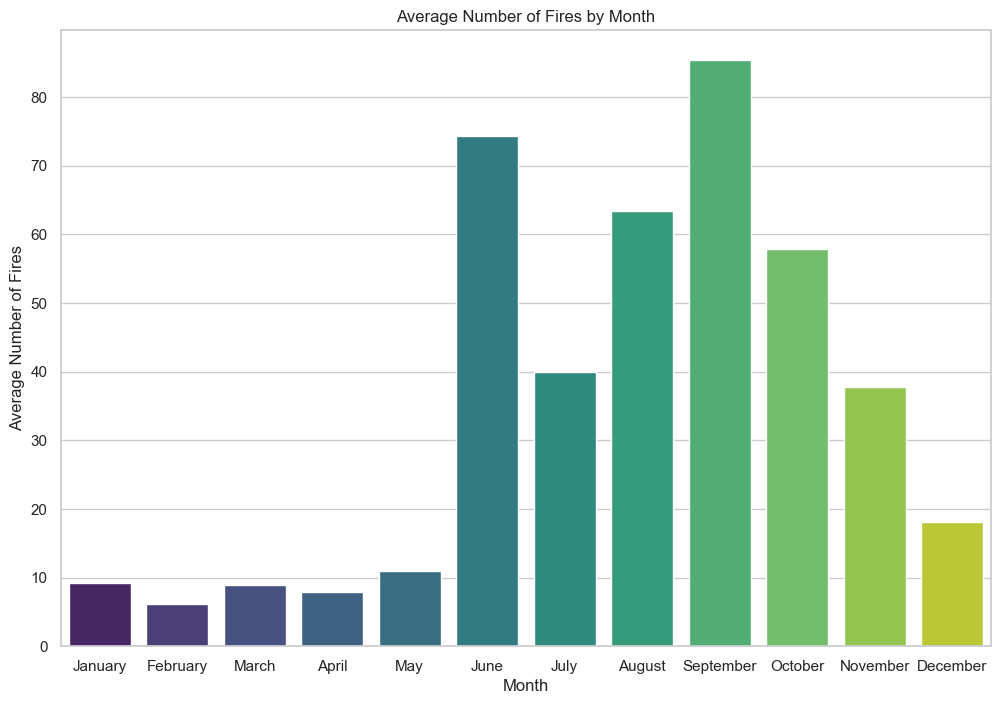

In [31]:
monthly_fire_avg = forest_fires_count_cities.groupby('Month')['count'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Month', y='count', data=monthly_fire_avg, palette='viridis')
plt.title('Average Number of Fires by Month')
plt.xlabel('Month')
plt.ylabel('Average Number of Fires')
plt.xticks(ticks=[i for i in range(12)], labels=month_names)
plt.show()

In [32]:
yearly_mean_turkey = turkey_climate.copy()
yearly_mean_turkey['Date'] = pd.to_datetime(yearly_mean_turkey[['Year', 'Month']].assign(DAY=1))
yearly_mean_turkey = yearly_mean_turkey.groupby(yearly_mean_turkey['Date'].dt.year)['AverageTemperature'].mean().reset_index()
yearly_mean_turkey.columns = ['Year', 'YearlyMeanTemperature']
yearly_mean_turkey = yearly_mean_turkey[yearly_mean_turkey['Year'] > 1755]


fig = px.line(yearly_mean_turkey, x='Year', y='YearlyMeanTemperature', 
              labels={'YearlyMeanTemperature': 'Average Temperature', 'Year': 'Year'},
              title='Average Annual Temperature Change')
fig.show()

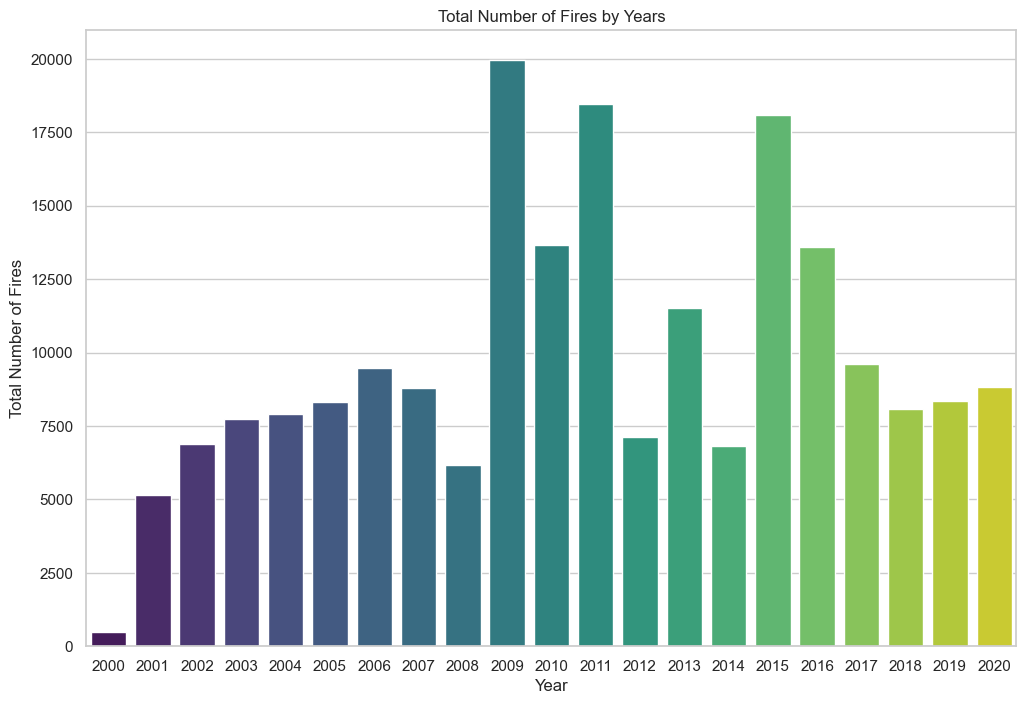

In [33]:
yearly_fire_count = forest_fires_count_cities.groupby('Year')['count'].sum().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Year', y='count', data=yearly_fire_count, palette='viridis')
plt.title('Total Number of Fires by Years')
plt.xlabel('Year')
plt.ylabel('Total Number of Fires')
plt.show()

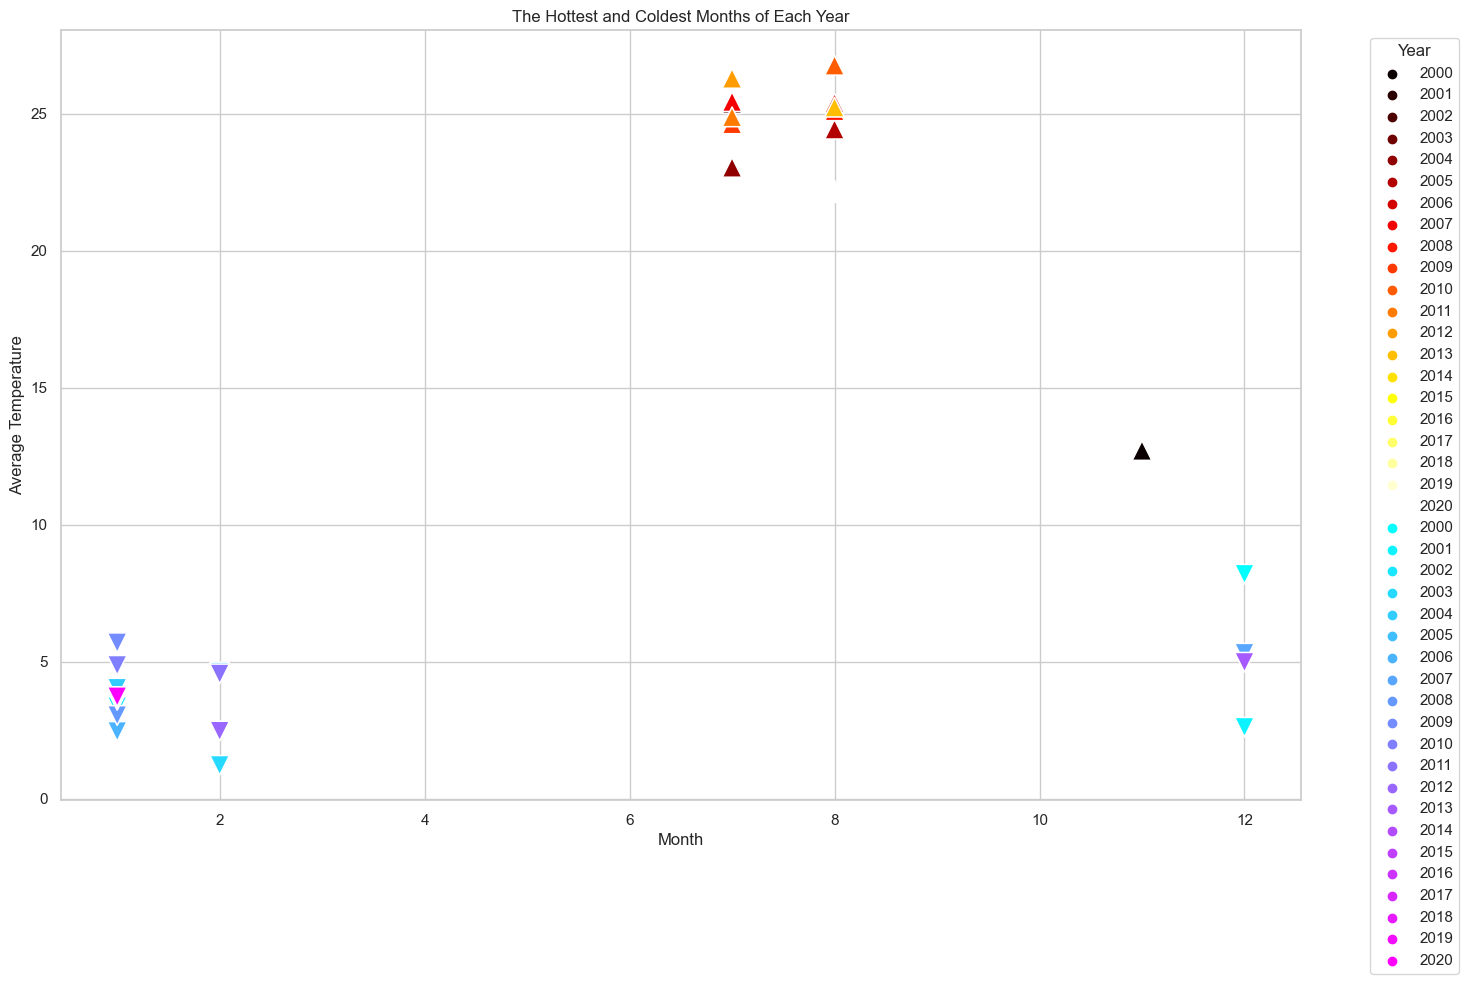

In [34]:
hottest_months = forest_fires_count_cities.loc[forest_fires_count_cities.groupby('Year')['AverageTemperature'].idxmax()]
coldest_months = forest_fires_count_cities.loc[forest_fires_count_cities.groupby('Year')['AverageTemperature'].idxmin()]

plt.figure(figsize=(16, 10))
sns.scatterplot(x='Month', y='AverageTemperature', hue='Year', data=hottest_months, marker='^', s=200, palette='hot', legend='full')
sns.scatterplot(x='Month', y='AverageTemperature', hue='Year', data=coldest_months, marker='v', s=200, palette='cool', legend='full')

plt.title('The Hottest and Coldest Months of Each Year')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Changing the polynomial regression model from yearly to monthly for predicting more accurately.

In [35]:
unique_cities = turkey_climate['City'].unique()

city_dfs = {}

for city in unique_cities:
    city_df = turkey_climate[turkey_climate['City'] == city]
    city_df = city_df.drop('City',axis = 1)
    city_dfs[city] = city_df

In [36]:
def create_monthly_dict(df):
    temperature_dict = {}

    for month in range(1, 13):
        month_data = pd.DataFrame(df[df['Month'] == month][['Year', 'AverageTemperature']].to_dict(orient='records'))
        temperature_dict[month] = month_data

    return temperature_dict

cities_montly_dict = {}

for i in unique_cities:
    cities_montly_dict[i] = create_monthly_dict(city_dfs[i])

In [37]:
def create_monthly_model(df, city, month):
    months = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 
              7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}
    

    df = df[city][month]
    year = np.array(df['Year'])
    temperature = np.array(df['AverageTemperature'])


    degree = 3
    coefficients = np.polyfit(year, temperature, degree)

    poly_function = np.poly1d(coefficients)

    fitted_values = np.array(poly_function(year))

    plt.scatter(year, temperature, label='Actual Data', color='blue')
    plt.plot(year, fitted_values, label=f'Polynomial Regression (Degree {degree})', color='red')
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.title(f'City: {city},  Month: {months[month]}')
    plt.legend()
    plt.show()

    return poly_function

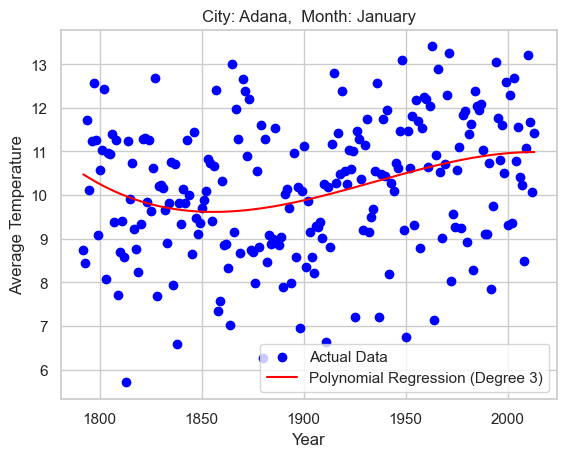

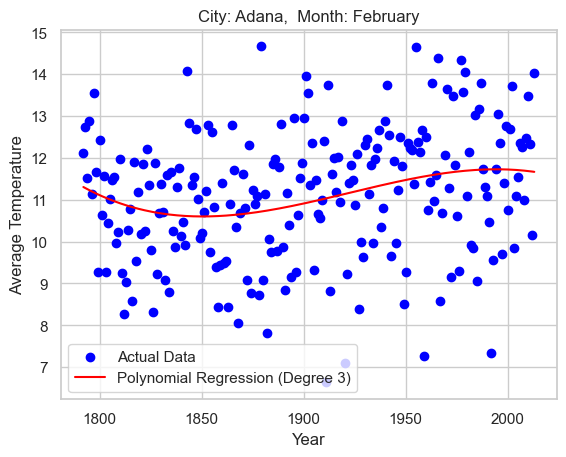

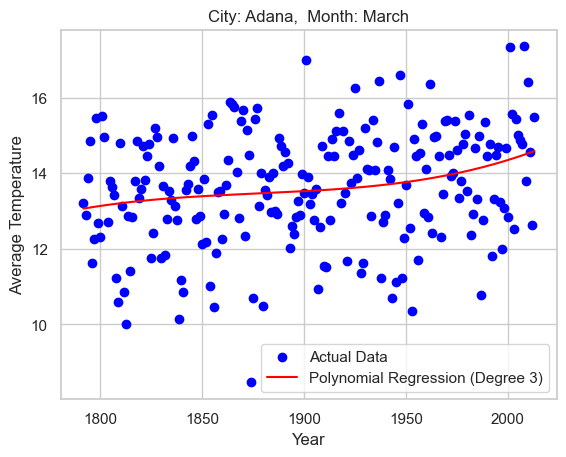

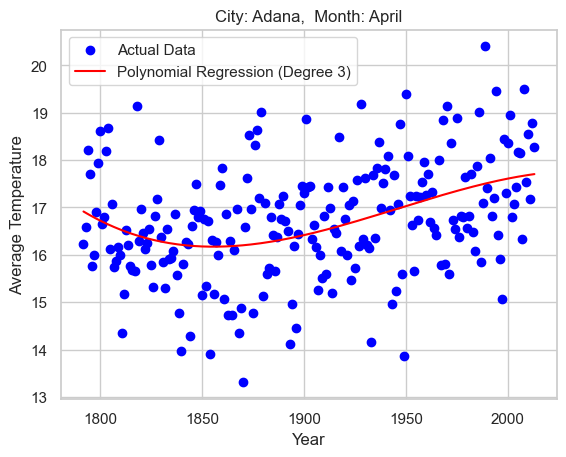

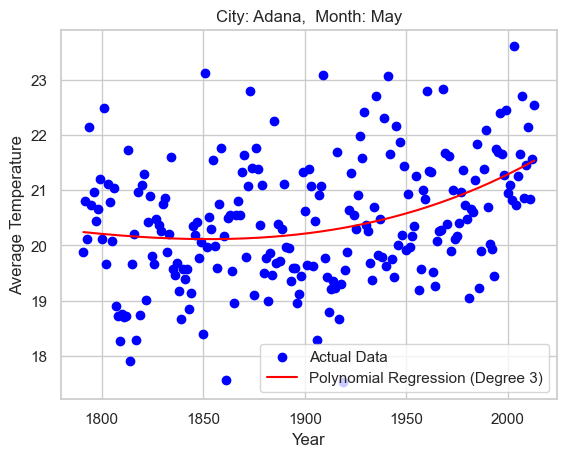

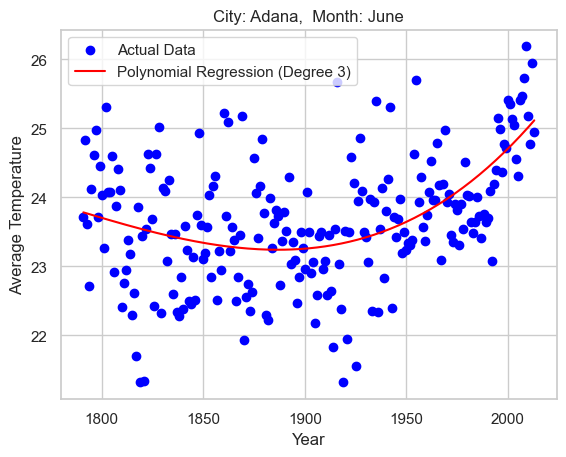

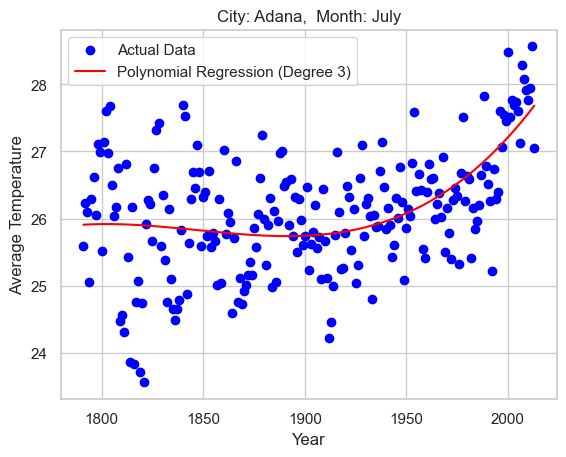

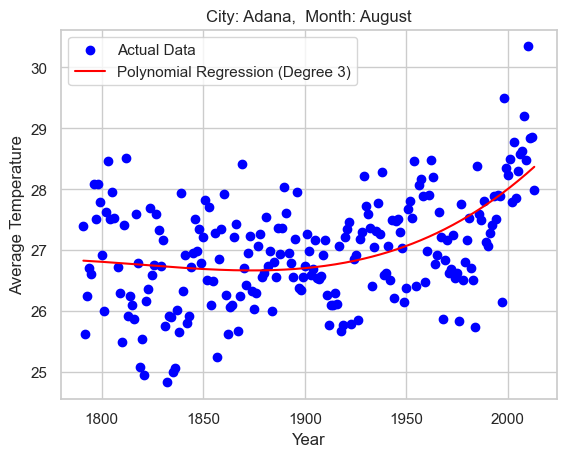

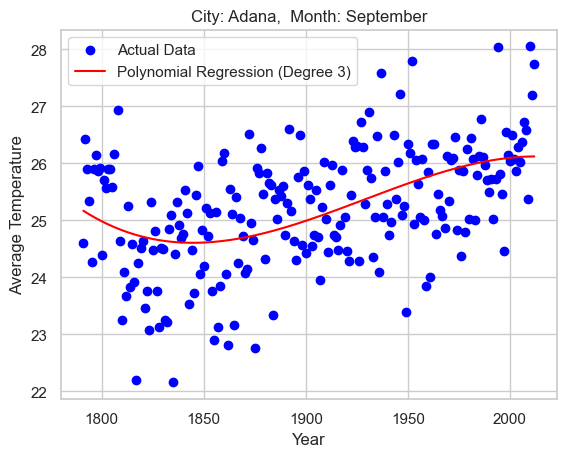

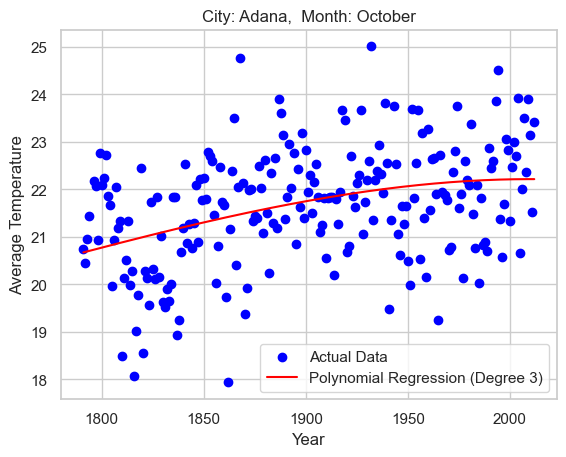

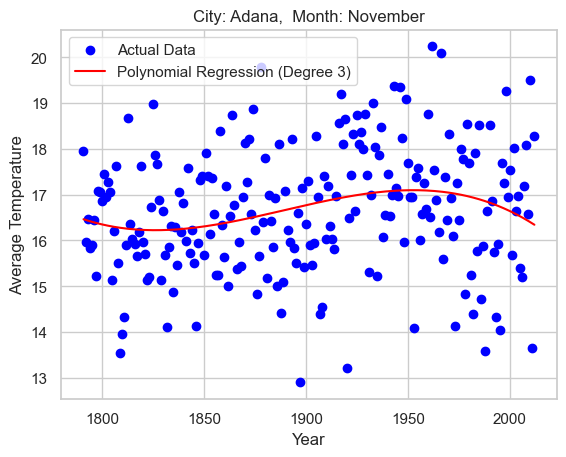

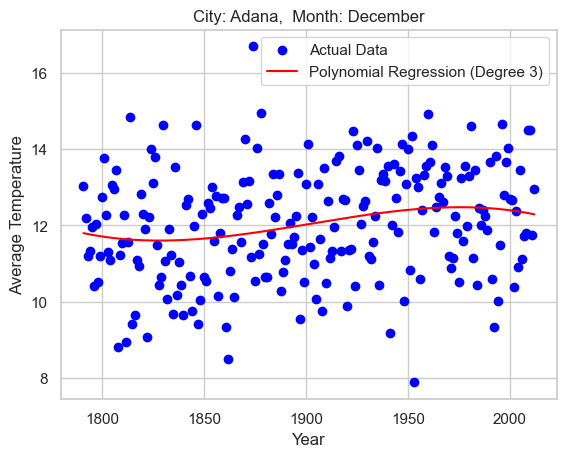

In [54]:
predicted_temperatures2025 = []
predicted_temperatures2050 = []
for i in range(1,13):    
    model = create_monthly_model(cities_montly_dict, "Adana", i)
    predicted_temperature2025 = model(2025)
    predicted_temperatures2025.append(predicted_temperature2025)
    predicted_temperature2050 = model(2050)
    predicted_temperatures2050.append(predicted_temperature2050)

In [55]:
months = {1:"Jan", 2:"Feb", 3:"Mar", 4:"Apr", 5:"May", 6:"Jun", 
              7:"Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11:"Nov", 12:"Dec"}
    

print("Predicted Average Temperatures for Adana\nIn 2025:\tIn 2050")
for i in range(len(predicted_temperatures2025)):
    print(f"{months[i+1]}: {predicted_temperatures2025[i]:.2f}\t{months[i+1]}: {predicted_temperatures2050[i]:.2f}")

Predicted Average Temperatures for Adana
In 2025:	In 2050
Jan: 10.96	Jan: 10.72
Feb: 11.55	Feb: 11.10
Mar: 14.84	Mar: 15.51
Apr: 17.76	Apr: 17.75
May: 21.79	May: 22.41
Jun: 25.55	Jun: 26.63
Jul: 28.20	Jul: 29.53
Aug: 28.75	Aug: 29.73
Sep: 26.09	Sep: 25.86
Oct: 22.21	Oct: 22.14
Nov: 15.92	Nov: 14.76
Dec: 12.11	Dec: 11.58


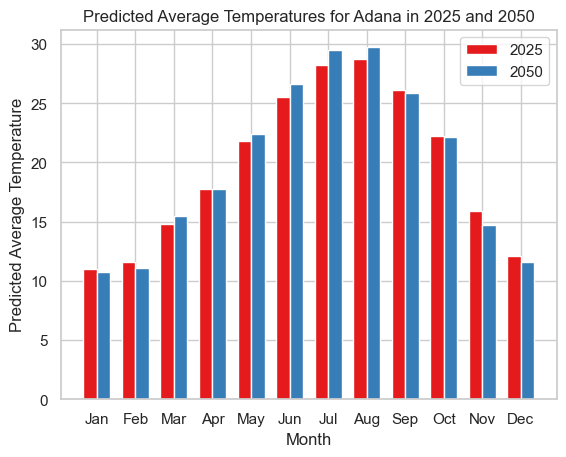

In [56]:
bar_width = 0.35
index = np.arange(len(months))

fig, ax = plt.subplots()
bar1 = ax.bar(index, predicted_temperatures2025, bar_width, label='2025')
bar2 = ax.bar(index + bar_width, predicted_temperatures2050, bar_width, label='2050')

ax.set_xlabel('Month')
ax.set_ylabel('Predicted Average Temperature')
ax.set_title('Predicted Average Temperatures for Adana in 2025 and 2050')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels([months[i] for i in range(1, 13)])
ax.legend()

plt.show()

Some preproccesing for getting the data fit to Random Forest model.

In [40]:
avg_satellite = forest_gdf.groupby('NearestCity')[['brightness', 'scan', 'track']].mean().reset_index()

forest_fires_count_cities['avg_brightness'] = forest_fires_count_cities['NearestCity'].map(avg_satellite.set_index('NearestCity')['brightness'])
forest_fires_count_cities['avg_scan'] = forest_fires_count_cities['NearestCity'].map(avg_satellite.set_index('NearestCity')['scan'])
forest_fires_count_cities['avg_track'] = forest_fires_count_cities['NearestCity'].map(avg_satellite.set_index('NearestCity')['track'])

forest_fires_count_cities

,NearestCity,acq_date,count,AverageTemperature,Year,Month,avg_brightness,avg_scan,avg_track
0,Adana,2000-11,104,12.714000,2000,11,325.893156,1.520546,1.188196
1,Adana,2000-12,7,8.201000,2000,12,325.893156,1.520546,1.188196
2,Adana,2001-01,2,7.201000,2001,1,325.893156,1.520546,1.188196
3,Adana,2001-02,1,7.011000,2001,2,325.893156,1.520546,1.188196
4,Adana,2001-04,4,12.502000,2001,4,325.893156,1.520546,1.188196
...,...,...,...,...,...,...,...,...,...
5282,Çorum,2020-07,10,21.577425,2020,7,320.369614,1.484995,1.171008
5283,Çorum,2020-08,4,22.211298,2020,8,320.369614,1.484995,1.171008
5284,Çorum,2020-09,41,21.232697,2020,9,320.369614,1.484995,1.171008
5285,Çorum,2020-10,12,18.287704,2020,10,320.369614,1.484995,1.171008


In [41]:
forest_gdf['acq_date'] = pd.to_datetime(forest_gdf['acq_date'])
forest_fires_count_cities['acq_date'] = pd.to_datetime(forest_fires_count_cities['acq_date'])

In [42]:
merged_df = pd.merge(forest_gdf, forest_fires_count_cities, on=['acq_date', 'NearestCity'], how='inner')
merged_df

,latitude,longitude,brightness,scan,track,acq_date,acq_time,confidence,bright_t31,frp,...,Month_x,geometry,NearestCity,count,AverageTemperature,Year_y,Month_y,avg_brightness,avg_scan,avg_track
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,815,60,294.4,13.2,...,11,POINT (35.35940 36.85270),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
1,36.7291,36.2161,306.7,1.3,1.1,2000-11-01,858,24,294.4,7.9,...,11,POINT (36.21610 36.72910),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
2,36.7543,35.3808,312.7,1.2,1.1,2000-11-01,858,69,300.3,8.1,...,11,POINT (35.38080 36.75430),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
3,36.7502,35.4614,309.5,1.2,1.1,2000-11-01,858,62,298.2,5.5,...,11,POINT (35.46140 36.75020),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
4,36.7479,35.4745,309.3,1.2,1.1,2000-11-01,858,61,298.3,5.4,...,11,POINT (35.47450 36.74790),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204992,41.6477,35.7601,310.0,1.9,1.4,2020-12-01,1012,69,287.2,27.9,...,12,POINT (35.76010 41.64770),Samsun,3,5.082869,2020,12,317.426701,1.406247,1.143961
204993,41.6441,35.7659,307.4,1.9,1.4,2020-12-01,1012,65,286.6,21.8,...,12,POINT (35.76590 41.64410),Samsun,3,5.082869,2020,12,317.426701,1.406247,1.143961
204994,39.3713,36.4376,306.6,1.2,1.1,2020-12-01,844,64,281.0,12.1,...,12,POINT (36.43760 39.37130),Sivas,2,5.082869,2020,12,321.408605,1.555540,1.194944
204995,39.3689,36.4510,306.3,1.2,1.1,2020-12-01,844,63,280.8,12.0,...,12,POINT (36.45100 39.36890),Sivas,2,5.082869,2020,12,321.408605,1.555540,1.194944


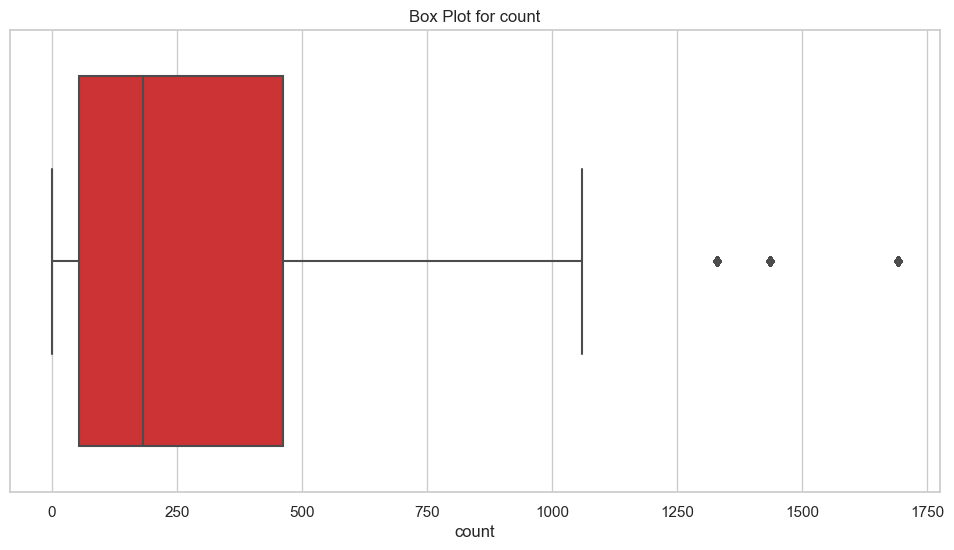

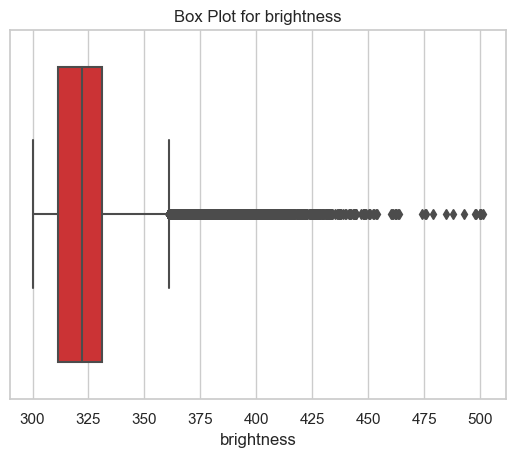

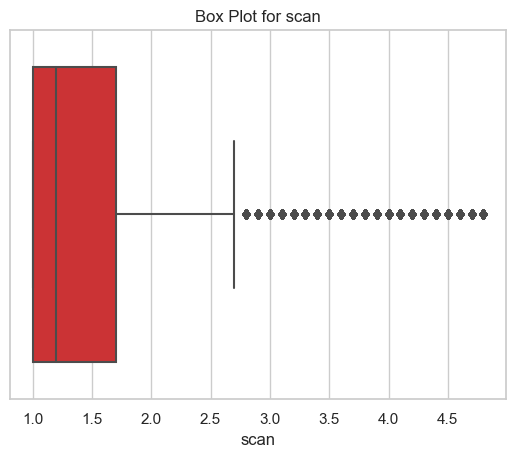

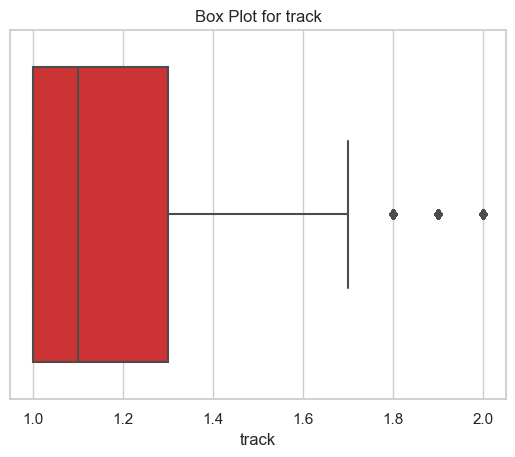

In [43]:
features_to_check = ['count','brightness', 'scan', 'track']

plt.figure(figsize=(12, 6))
for feature in features_to_check:
    sns.boxplot(x=merged_df[feature])
    plt.title(f'Box Plot for {feature}')
    plt.show()

In [44]:
from scipy import stats

features_to_check = ['count','brightness', 'scan', 'track', 'avg_brightness','avg_scan','avg_track']

outliers = []
for feature in features_to_check:
    z_scores = stats.zscore(merged_df[feature])
    
    threshold = 3  
    outliers.extend(merged_df.index[np.abs(z_scores) > threshold])

merged_df_no_outliers = merged_df.drop(list(set(outliers)))

print("Outliers:")
print(merged_df.iloc[outliers])

Outliers:
        latitude  longitude  brightness  scan  track   acq_date  acq_time  \
71387    38.3230    41.0887       321.6   1.8    1.3 2009-09-01       838   
71388    37.2557    39.7143       344.7   1.6    1.2 2009-09-01       839   
71389    37.2448    39.7110       331.1   1.6    1.2 2009-09-01       839   
71390    37.7841    40.6381       330.3   1.8    1.3 2009-09-01       839   
71391    38.0697    41.4373       343.8   1.0    1.0 2009-09-01      1021   
...          ...        ...         ...   ...    ...        ...       ...   
204335   41.1720    32.6397       301.3   1.7    1.3 2020-11-01       914   
204336   41.1734    32.6286       300.4   1.0    1.0 2020-11-01      1049   
204337   41.1730    32.6374       301.1   1.1    1.0 2020-11-01       856   
204338   41.2586    31.4230       304.2   1.0    1.0 2020-11-01      1107   
204972   41.2585    31.4185       300.3   1.1    1.1 2020-12-01      1049   

        confidence  bright_t31   frp  ...  Month_x               

In [45]:
merged_df_no_outliers

,latitude,longitude,brightness,scan,track,acq_date,acq_time,confidence,bright_t31,frp,...,Month_x,geometry,NearestCity,count,AverageTemperature,Year_y,Month_y,avg_brightness,avg_scan,avg_track
0,36.8527,35.3594,306.0,2.1,1.4,2000-11-01,815,60,294.4,13.2,...,11,POINT (35.35940 36.85270),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
1,36.7291,36.2161,306.7,1.3,1.1,2000-11-01,858,24,294.4,7.9,...,11,POINT (36.21610 36.72910),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
2,36.7543,35.3808,312.7,1.2,1.1,2000-11-01,858,69,300.3,8.1,...,11,POINT (35.38080 36.75430),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
3,36.7502,35.4614,309.5,1.2,1.1,2000-11-01,858,62,298.2,5.5,...,11,POINT (35.46140 36.75020),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
4,36.7479,35.4745,309.3,1.2,1.1,2000-11-01,858,61,298.3,5.4,...,11,POINT (35.47450 36.74790),Adana,104,12.714000,2000,11,325.893156,1.520546,1.188196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204992,41.6477,35.7601,310.0,1.9,1.4,2020-12-01,1012,69,287.2,27.9,...,12,POINT (35.76010 41.64770),Samsun,3,5.082869,2020,12,317.426701,1.406247,1.143961
204993,41.6441,35.7659,307.4,1.9,1.4,2020-12-01,1012,65,286.6,21.8,...,12,POINT (35.76590 41.64410),Samsun,3,5.082869,2020,12,317.426701,1.406247,1.143961
204994,39.3713,36.4376,306.6,1.2,1.1,2020-12-01,844,64,281.0,12.1,...,12,POINT (36.43760 39.37130),Sivas,2,5.082869,2020,12,321.408605,1.555540,1.194944
204995,39.3689,36.4510,306.3,1.2,1.1,2020-12-01,844,63,280.8,12.0,...,12,POINT (36.45100 39.36890),Sivas,2,5.082869,2020,12,321.408605,1.555540,1.194944


*Random Forest*

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = merged_df[['avg_brightness', 'avg_scan', 'avg_track', 'AverageTemperature','Year_y', 'Month_y', 'NearestCity']]
y = merged_df['count']

X = pd.get_dummies(X, columns=['NearestCity'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 39.8989518902439
Root Mean Squared Error: 6.316561714274934
